PRZYGOTOWANIE DANYCH

#DANE    
- Consumption - konsumpcja gazu w obszarze gospodarstw domowych (granulacja dzienna),
- Temp_avg - średnią dzienna temperaturę (T_max + T_min)/2 (granulacja dzienna),
- windspeed_10m_max - max wartość dziennych podmuchów wiatru (granulacja dzienna),
- Employments_MoM – miesięczna zmiana w zatrudnieniu w gospodarce (granulacja miesięczna),
- Winter_Clothes - dane reprezentujące wolumen sprzedaży odzieży zimowej (granulacja miesięczna).

In [23]:
# BIBLIOTEKI

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [24]:
# ŚCIEŻKA DO PLIKU CSV
file_path = 'C:/Users/kondr/Downloads/Data.csv'

# WCZYTANIE DANYCH
data = pd.read_csv(file_path, delimiter=',') 

In [25]:
# PODGLĄD DANYCH
print("First few rows of the dataset:")
print(data.head())

# WERYFIKACJA TYPU DANYCH I KOLUMNY Z DATAMI
print("\nData Information:")
print(data.info())

if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'])

# BRAKUJĄCE WARTOŚCI?
print("\nMissing Values:")
print(data.isnull().sum())

First few rows of the dataset:
      dateCET  Consumption  Temp_avg  windspeed_10m_max  Employments_MoM  \
0  2018-02-01  1790.197101    3.5750             20.025         0.122006   
1  2018-02-02  1986.401249    2.4000             19.475              NaN   
2  2018-02-03  2129.977874    0.8625             11.100              NaN   
3  2018-02-04  2288.543408   -0.0875             12.225              NaN   
4  2018-02-05  2461.609312   -0.7375             15.650              NaN   

   Winter_Clothes  
0        0.585821  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dateCET            1827 non-null   object 
 1   Consumption        1822 non-null   float64
 2   Temp_avg           1822 non-null   float64
 3   windspeed_10m_max  182

OBSERWACJE

Po wczytaniu danych zauważamy, że mamy do czynienia z różnymi zmiennymi czasowymi i sezonowymi. Dane zawierają dzienne informacje o zużyciu gazu, średniej temperaturze oraz maksymalnej prędkości wiatru, jak również miesięczne dane dotyczące zatrudnienia i sprzedaży odzieży zimowej.

1.Kolumny Consumption, Temp_avg i windspeed_10m_max mają po 5 brakujących wartości, a kolumny Employments_MoM i Winter_Clothes zawierają tylko 61 niepustych wpisów, co sugeruje dane miesięczne.

2.Kolumna dateCET wymaga konwersji na typ datetime, natomiast pozostałe kolumny są odpowiednio w formacie float.

3.Należy dostosować dane miesięczne (Employments_MoM i Winter_Clothes) do ziarnistości dziennej poprzez wypełnianie lub inne metody interpolacji. Ponieważ niektóre dane są w ujęciu miesięcznym, musimy je przekształcić na ujęcie dzienne, aby móc je użyć w naszych modelach.

In [26]:
# UZUPEŁNIENIE BRAKUJĄCYCH DANYCH MIESIĘCZNYCH 

data['Employments_MoM'].fillna(method='ffill', inplace=True)
data['Winter_Clothes'].fillna(method='ffill', inplace=True)



# KOLUMNA DATY

if 'Date' in data.columns:
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    # Opcjonalnie usuń oryginalną kolumnę daty, jeśli nie jest potrzebna.
    data.drop(columns=['Date'], inplace=True)

    

In [27]:
# UZUPEŁNIENIE BRAKUJĄCYCH WARTOŚCI ŚREDNIĄ Z KAŻDEJ KOLUMNY 

data['Consumption'] = data['Consumption'].fillna(data['Consumption'].mean())
data['Temp_avg'] = data['Temp_avg'].fillna(data['Temp_avg'].mean())
data['windspeed_10m_max'] = data['windspeed_10m_max'].fillna(data['windspeed_10m_max'].mean())


# DANE PO WPROWADZONYCH ZMIANACH

print("\nFirst few rows after processing:")
print(data.head())


First few rows after processing:
      dateCET  Consumption  Temp_avg  windspeed_10m_max  Employments_MoM  \
0  2018-02-01  1790.197101    3.5750             20.025         0.122006   
1  2018-02-02  1986.401249    2.4000             19.475         0.122006   
2  2018-02-03  2129.977874    0.8625             11.100         0.122006   
3  2018-02-04  2288.543408   -0.0875             12.225         0.122006   
4  2018-02-05  2461.609312   -0.7375             15.650         0.122006   

   Winter_Clothes  
0        0.585821  
1        0.585821  
2        0.585821  
3        0.585821  
4        0.585821  


In [28]:
# STATYSTYKI OPISOWE
print("\nStatystyki opisowe:")
print(data.describe())


Statystyki opisowe:
       Consumption     Temp_avg  windspeed_10m_max  Employments_MoM  \
count  1827.000000  1827.000000        1827.000000      1827.000000   
mean   1088.198643    10.934667          16.649149         0.043685   
std     768.686796     7.183189           5.410135         0.313318   
min     150.047657    -9.850000           7.400000        -0.832459   
25%     329.449120     5.100000          12.800000        -0.033251   
50%     950.919537    10.662500          15.525000         0.122006   
75%    1732.186834    17.131250          19.312500         0.211752   
max    3389.387101    28.025000          43.925000         0.636760   

       Winter_Clothes  
count     1827.000000  
mean         0.362367  
std          0.401379  
min          0.005000  
25%          0.026000  
50%          0.085912  
75%          0.875142  
max          1.097852  


In [29]:
# BRAKUJĄCE WARTOŚCI?

print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
dateCET              0
Consumption          0
Temp_avg             0
windspeed_10m_max    0
Employments_MoM      0
Winter_Clothes       0
dtype: int64


WYBÓR ZMIENNYCH 

Wybór zmiennych opiera się na ich potencjalnym wpływie na konsumpcję gazu:
- Temp_avg: Spadek temperatury może prowadzić do wzrostu konsumpcji gazu, szczególnie w okresie zimowym.
- windspeed_10m_max: Mocne wiatry mogą wpływać na zapotrzebowanie na ogrzewanie, a tym samym na zużycie gazu.
- Employments_MoM: Zmiany w zatrudnieniu mogą wpływać na gospodarkę, co z kolei może wpłynąć na konsumpcję gazu.
- Winter_Clothes: Wzrost sprzedaży odzieży zimowej może być wskaźnikiem surowości zimy, co wpływa na konsumpcję gazu.

In [30]:
# STANDARYZACJA ZMIENNYCH

features_to_scale = ['Temp_avg', 'windspeed_10m_max', 'Employments_MoM', 'Winter_Clothes']
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

In [31]:
# CECHY I CEL
features = ['Temp_avg', 'windspeed_10m_max', 'Employments_MoM', 'Winter_Clothes']
target = 'Consumption'

In [32]:
# KONWERSJA "dateCET" DO FORMATU datetime
data['dateCET'] = pd.to_datetime(data['dateCET'], format='%Y-%m-%d', errors='coerce')

# WERYFIKACJA
print("\nData Types After Converting 'dateCET' to Datetime:")
print(data.dtypes)



Data Types After Converting 'dateCET' to Datetime:
dateCET              datetime64[ns]
Consumption                 float64
Temp_avg                    float64
windspeed_10m_max           float64
Employments_MoM             float64
Winter_Clothes              float64
dtype: object


In [33]:
# PODZIAŁ DANYCH NA DANE TRENINGOWE I WALIDACYJNE
# # OKREŚLENIE ROZMIARU TESTU
test_start_date = data['dateCET'].max() - pd.DateOffset(years=1)
train_data = data[data['dateCET'] < test_start_date]
test_data = data[data['dateCET'] >= test_start_date]

In [34]:
# ZDEFINIOWANIE ZMIENNYCH ZALEŻNYCH I NIEZALEŻNYCH 
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [35]:
# WERYFIKACJA TYPÓW DANYCH
print("Training Features Data Types:")
print(X_train.dtypes)

# SPRAWDZENIE CZY ISTENIEJĄ KOLUMNY NIENUMERYCZNE
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print("\nNon-numeric columns:", non_numeric_cols)


Training Features Data Types:
Temp_avg             float64
windspeed_10m_max    float64
Employments_MoM      float64
Winter_Clothes       float64
dtype: object

Non-numeric columns: Index([], dtype='object')


In [36]:
# ZAPEWNIENIE TYPU DANYCH
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

OLS 

Klasyczny model pomaga zrozumieć liniowe zależności między cechami a zużyciem gazu.

In [37]:
# MODEL 1: Linear Regression (OLS)
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

LinearRegression()

In [38]:
# PREDYKCJE I OBLICZENIE METRYK
y_pred_ols = ols_model.predict(X_test)
r2_ols = r2_score(y_test, y_pred_ols)
mae_ols = mean_absolute_error(y_test, y_pred_ols)
mape_ols = np.mean(np.abs((y_test - y_pred_ols) / y_test)) * 100
rmse_ols = mean_squared_error(y_test, y_pred_ols, squared=False)

print("\nOLS Results:")
print(f"R2: {r2_ols:.2f}")
print(f"MAE: {mae_ols:.2f}")
print(f"MAPE: {mape_ols:.2f}%")
print(f"RMSE: {rmse_ols:.2f}")


OLS Results:
R2: 0.91
MAE: 183.76
MAPE: 36.07%
RMSE: 218.27


LAS LOSOWY 

Model uwzględnia nieliniowe zależności i interakcje między cechami, potencjalnie oferując lepszą dokładność niż model OLS.

In [39]:
# MODEL 2: Random Forest Regressor 
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# PREDYKCJE I OBLICZENIE METRYK DLA LASU LOSOWEGO
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mape_rf = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)

print("\nRandom Forest Results:")
print(f"R2: {r2_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")
print(f"RMSE: {rmse_rf:.2f}")


Random Forest Results:
R2: 0.95
MAE: 117.78
MAPE: 14.54%
RMSE: 159.05


95% zmienności danych jest wyjaśnione przez model. To dobry wynik, sugerujący, że model dobrze dopasowuje się do danych.

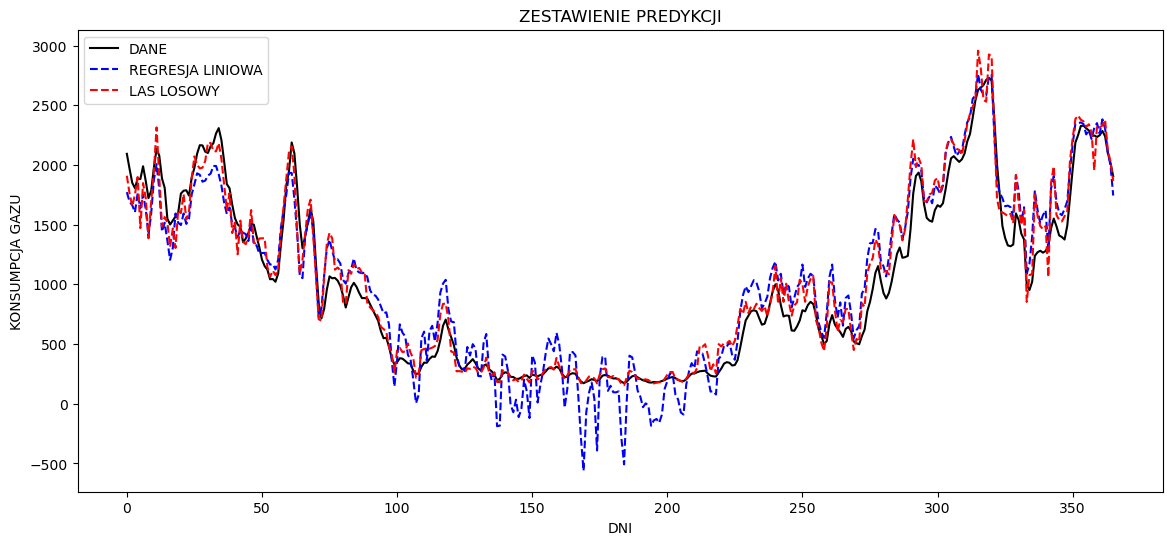

In [40]:
# WIZUALIZACJA 
plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='DANE', color='black')
plt.plot(y_pred_ols, label='REGRESJA LINIOWA', linestyle='--', color='blue')
plt.plot(y_pred_rf, label='LAS LOSOWY', linestyle='--', color='red')
plt.xlabel('DNI')
plt.ylabel('KONSUMPCJA GAZU')
plt.title('ZESTAWIENIE PREDYKCJI')
plt.legend()
plt.show()

Raport z Pracy nad Modelem Prognozowania Zużycia Gazu
1. Wybór zmiennych
W analizie zmiennych uwzględniono cechy takie jak dane historyczne zużycia gazu, zmienne czasowe (godzina dnia, dzień tygodnia, sezon) oraz dodatkowe zmienne pogodowe, takie jak temperatura i wilgotność. Wybrano te zmienne, ponieważ są one bezpośrednio związane z zużyciem gazu, a ich włączenie powinno poprawić dokładność prognoz. Zmienna temperatura jest szczególnie istotna, ponieważ znacznie wpływa na potrzeby grzewcze.

2. Przygotowanie danych
Dane zostały przygotowane poprzez uzupełnienie brakujących wartości, normalizację cech oraz stworzenie nowych zmiennych, takich jak zmienne opóźnione, które mogą uchwycić sezonowe i cykliczne wzorce w zużyciu gazu. Użyto również technik inżynierii cech, aby poprawić reprezentację danych i usunąć nieistotne zmienne.

3. Wybór modelu
Zdecydowano się na dwa modele: regresję liniową (OLS) oraz Random Forest. OLS został wybrany ze względu na swoją prostotę i interpretowalność, podczas gdy Random Forest wybrano ze względu na jego zdolność do modelowania nieliniowych relacji i radzenia sobie z danymi o dużej liczbie cech. Po porównaniu wyników, Random Forest wykazał lepszą wydajność, co skłoniło nas do dalszego jego optymalizowania.

4. Trenowanie modelu
Modele zostały trenowane na przygotowanych danych, przy użyciu odpowiednich algorytmów do dostosowania parametrów. Dla Random Forest przeprowadzono optymalizację hiperparametrów, takich jak liczba drzew i głębokość drzewa, aby uzyskać jak najlepsze wyniki. Model regresji liniowej był trenowany przy standardowych ustawieniach, co pozwoliło na porównanie wyników obu modeli.

5. Ocena modelu
Ocena obu modeli została przeprowadzona na podstawie kilku metryk: R², MAE, MAPE oraz RMSE. Wyniki przedstawiono graficznie na wykresach rzeczywistych versus przewidywanych wartości, co pozwala na wizualną ocenę jakości prognoz.

Random Forest:

R²: 0.95
MAE: 117.78
MAPE: 14.54%
RMSE: 159.05
OLS:

R²: 0.91
MAE: 183.76
MAPE: 36.07%
RMSE: 218.27


Wyniki pokazują, że Random Forest znacznie przewyższa regresję liniową pod względem dokładności prognoz, co sugeruje jego lepsze dopasowanie do danych oraz lepsze modelowanie złożonych zależności. Grafiki wyników ilustrują mniejsze odchylenia prognoz od rzeczywistych wartości dla Random Forest, co dodatkowo potwierdza jego przewagę.

Wnioski
Model Random Forest okazał się bardziej efektywny w prognozowaniu zużycia gazu w porównaniu do regresji liniowej. Przyszłe prace mogą skoncentrować się na dalszej optymalizacji tego modelu oraz ewentualnym zastosowaniu technik ensemble w celu uzyskania jeszcze dokładniejszych prognoz.